<center>
<h1><b>Text-to-Text tasks with Azure Open AI</b>
</center>

# Objectives

- To illustrate prompt engineering for text-to-text tasks using Azure Open AI.
- To illustrate evaluation of LLMs for text-to-text tasks using appropriate metrics (e.g., ROUGE score and BERTscore).

# Operationalizing Generative AI

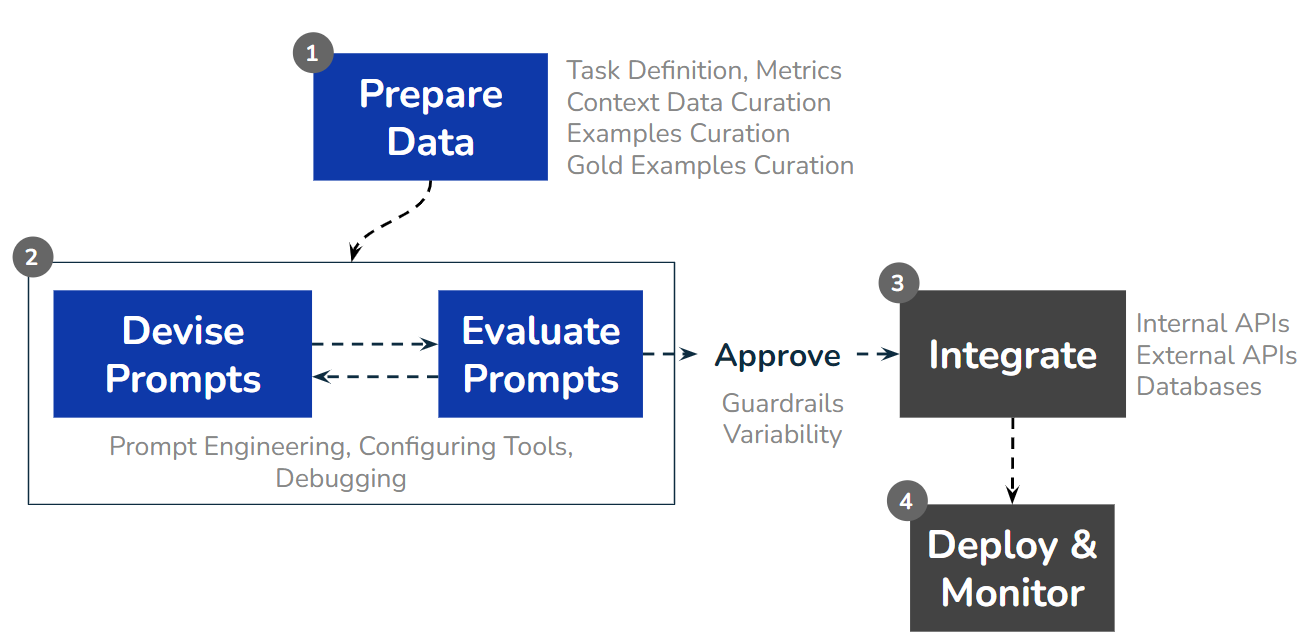

# Setup

Note: This notebook needs to be executed with a GPU runtime since we load and use a transformer model to evaluate the text-to-text tasks. Transformer models benefit from parallel execution offered by a GPU runtime (code in this notebook runs up to 4 times faster). See screenshots below to create a GPU runtime on a Colab instance.

*Step 1:*

Select the `Runtime` option from the main menu and select the `Change runtime type` from the dropdown.

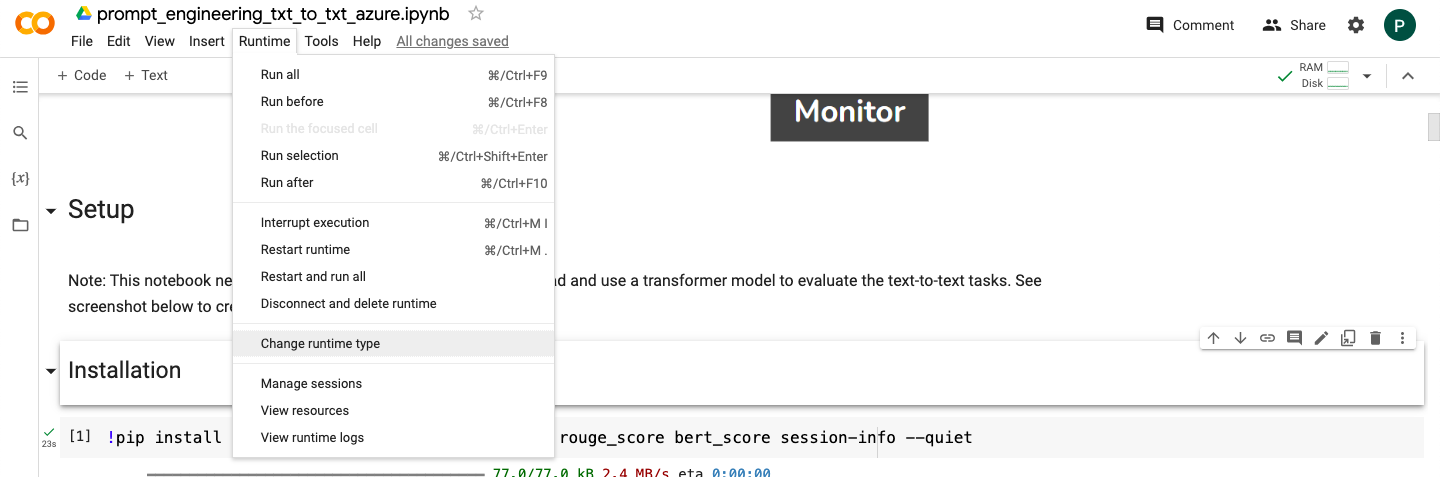

Select `T4 GPU` from the options presented under Hardware accelerator.

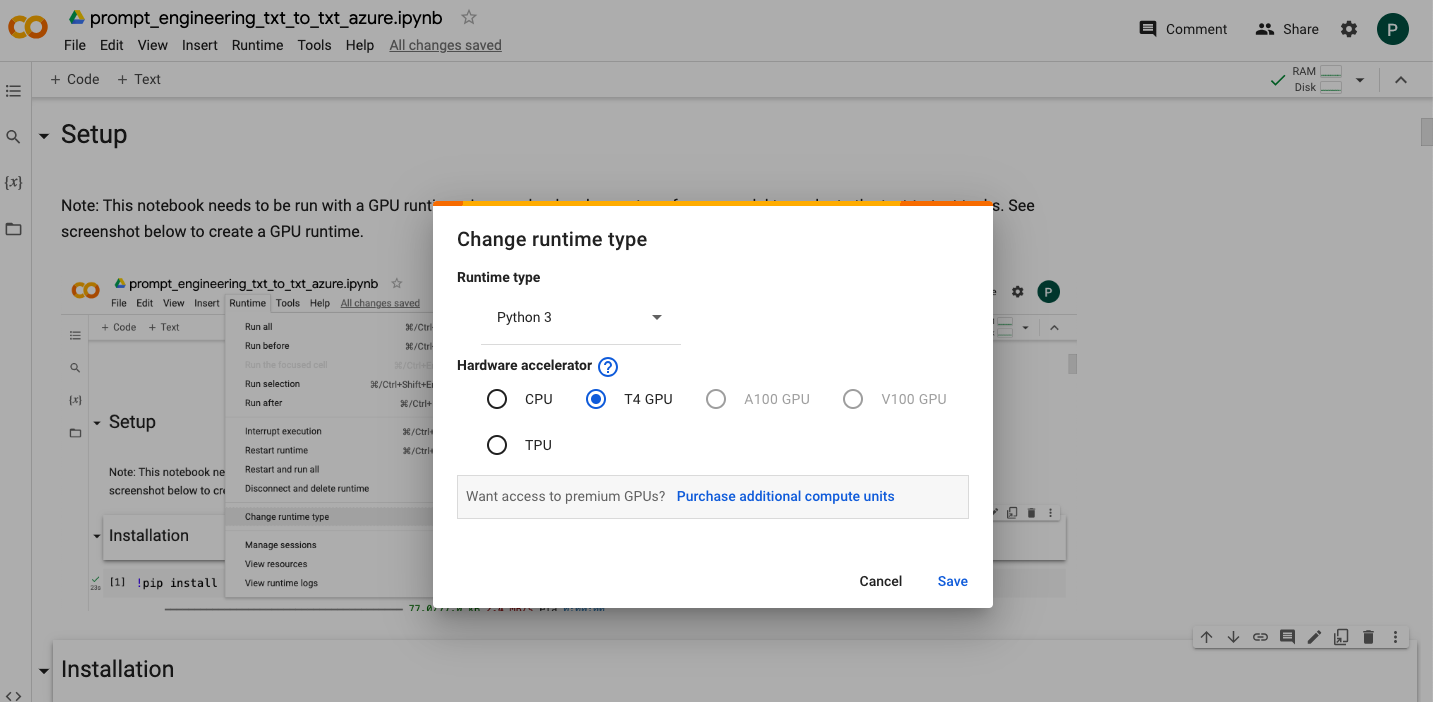

You should now see the T4 GPU mentioned in the runtime logo (screenshot below)

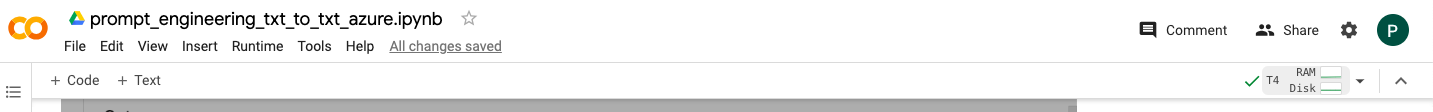

## Installation

In [ ]:
!pip install openai tiktoken datasets evaluate rouge_score bert_score session-info --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
import openai
import json
import tiktoken
import evaluate
import session_info

import numpy as np
import pandas as pd

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

In [ ]:
session_info.show()

## Authentication

In [ ]:
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

In [ ]:
creds = json.loads(data)

In [ ]:
openai.api_key = creds["AZURE_OPENAI_KEY"]
openai.api_base = creds["AZURE_OPENAI_ENDPOINT"]
openai.api_type = creds["AZURE_OPENAI_APITYPE"]
openai.api_version = creds["AZURE_OPENAI_APIVERSION"]

In [ ]:
chat_model_id = creds["CHATGPT_MODEL"]

## Utilities

Token counter to keep track of the completion window available in the prompt.

In [ ]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

# Text $→$ Text generation

A text $→$ text generation task involves the generation of a relevant response to the input depending on the task at hand. Examples include:

 - Summarization (abstractive or extractive)
 - Question Answering (including multiple choice)
 - Matching a premise to a hypothesis

The key thing to note here is that unlike the case of text classification where the labels belong to a known set, text-text generation is more abstract. For example, there is no "standard" summary of a customer service request; the quality of summary might vary with the human who is creating the summary. This facet of generating text output given input text complicates the performance evaluation of LLMs on these tasks.

In this notebook, we will take a closer look at two important text $→$ text tasks, setting up the problems, metrics, evaluations with a view to devise prompts that achieve high performance on these evaluations.

Solutions for text $\rightarrow$ text tasks can be built using LLM machinery using the following steps.

>*Step 1:* Frame the task as a combination of objective and metric.
>
>*Step 2:* Assemble data (i.e., examples and gold examples).
>
>*Step 3:* Design prompts using best practises such as few-shot, CoT, ReAct and evaluate them on gold examples.

## Task 1: Summarization

### Step 1: Define objectives and metrics

Input text can be summarized in two ways:
- Abstractive (a gist of the input).
- Extractive (a selection of key sentences from the input).

In order to evaluate model predictions, we compare the model predictions with the ground truth on a sample of human-annotated gold examples. Common metrics used to evaluate summarization outputs are ROUGE and BERTScore. Another method used to judge the quality of a summary is to use another LLM to assign a quality rating to the summary. In this case, we could also specify specific attributes of an ideal summary (for e.g., conciseness, clarity of exposition).

Let us look at each of these metrics in turn.

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

ROUGE takes a exact match approach to compare the prediction from the model with the human reference summary. ROUGE relies on matches of n-grams between the AI-generated summary and the human generated summary (depicted in the figure below).

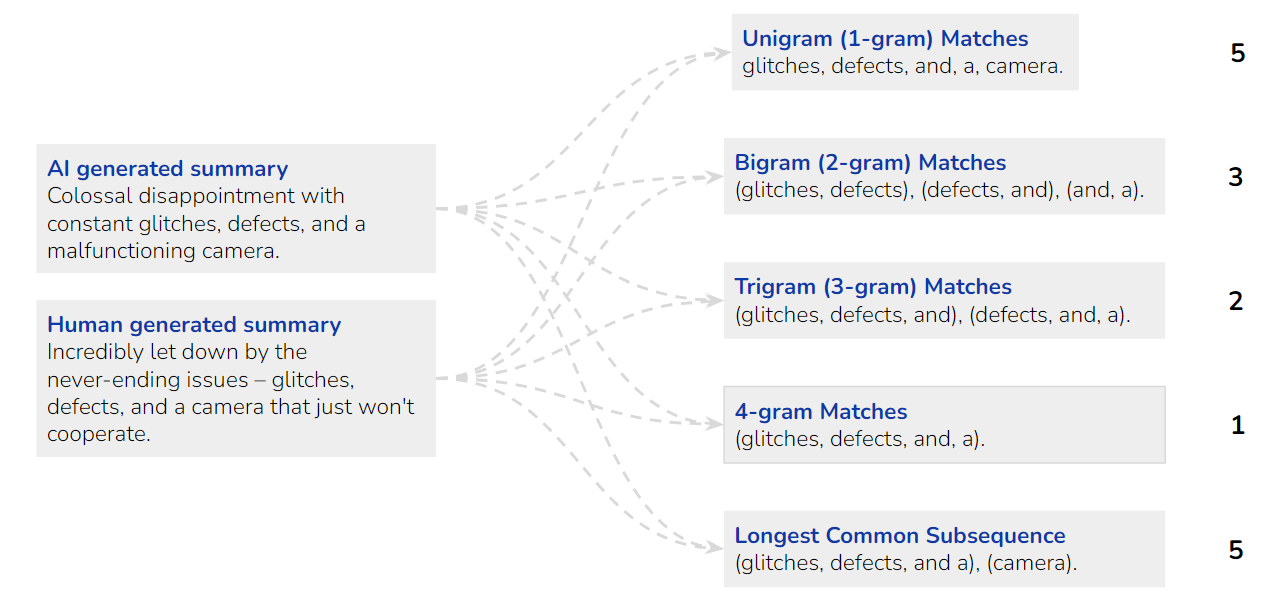

The $\text{ROUGE}_{N}$ score is computed using the ratio of the number of n-gram matches to the total number of n-grams in the human generated summary. However, we still have to make a choice whether unigram, bigram, or any other n-gram should be used.

To solve this conundrum, a common variant of ROUGE that is used to generate a comparison metric is $\text{ROUGE}_{\text{L}}$, where we first compute the recall and precision of the longest common subsequence and then compute the harmonic mean of these values (punctuation and case of the word are disregarded).

In [ ]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

As seen in the figure above, the length of the largest common subsequence between the two summaries is 5. The number of unigrams in the AI-generated summary is 10 and the number of unigrams in the human generated summary is 17. From these measures, we can compute $\text{ROUGE}_{\text{L}}$ like so:

In [ ]:
r_lcs, p_lcs = 5/17, 5/10
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs) # rouge-L

0.37037037037037035

One important limitation of ROUGE is that it accounts for exact matches. This means that a summary that uses semantically close words would receive a poor score despite capturing the intent of the human summary. For extractive summarization ROUGE would be a good metric, but for abstractive summarization it would be too harsh.

Hence we need a new metric that focuses on the meaning of the words in the summary rather than an exact match.

#### BERTScore

To illustrate the computation of the BERTScore, consider the following two summary outputs (one from a generative AI model and another from a human).

In [ ]:
ai_generated_summary = "Major issues, malfunctioning camera."
human_generated_summary = "Severely disappointed, constant problems."

In [ ]:
print(ai_generated_summary)
print(human_generated_summary)

Major issues, malfunctioning camera.
Severely disappointed, constant problems.


Look at the two summaries presented above. Though the choice of words is not exactly the same, both are close in intent.

BERTScore focuses on the semantic similarity between two pieces of text and hence is a better alternative to ROUGE for abstractive summarization tasks. As an illustration, the computation of BERTScore for two sentences is shown in the following figure.

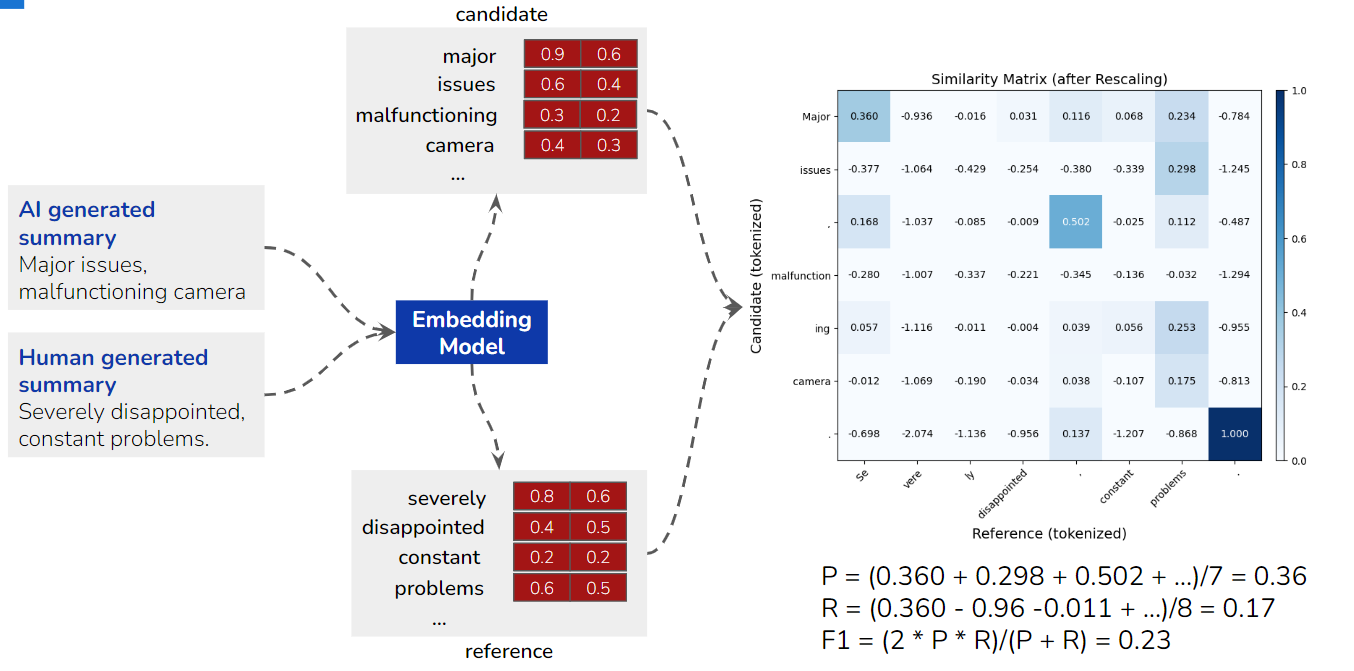

As seen in the figure above, the candidate text (i.e., the AI-generated summary) and the reference text (i.e., the human generated summary) are tokenized and assigned a numeric representation. In this representation, tokens that are correlated with each other lie close to each other (in the space defined by the numeric representation). All pairwise correlations between the tokens of the candidate and the reference are then collected in a table.

For precision ($P$), we average the maximum correlation scores for each token in the *candidate*. For recall ($R$), we average the maximum correlation scores for each token in the *reference*. The F1 score is estimated as: $(2 \times P \times R)/(P+ R)$.

We report the F1 score as the BERTScore.

#### LLM rating LLM output

Another commonly used method to automate evaluations is to use a different model (e.g., GPT-4, LLaMA2) to evaluate the output from the model used to execute the text-to-text task (in this case GPT-3.5). The figure below illustrates the steps involved.

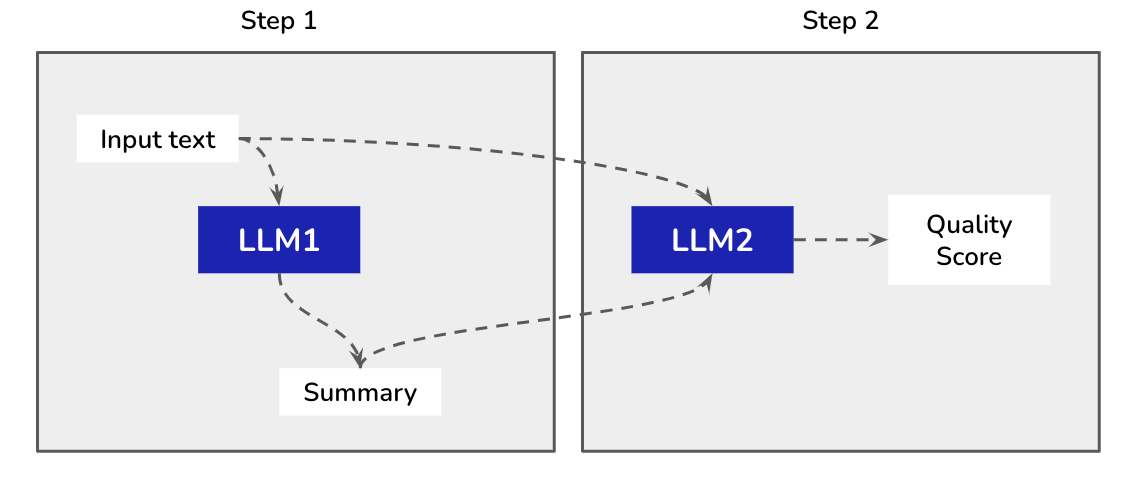

As an example, consider that we are using an LLM to summarize conversations between sales support agents and customers. The following system message and the user message template could be used to prompt a 'rating' LLM based on the output of the 'summarization' LLM.

In [ ]:
rating_system_message = """
You will be presented a conversation and an AI generated summary of the conversation as the input.
This input will be delimited by triple backticks, that is ```.
In the input the conversation will begin with ###Conversation.
The AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the conversation presented as the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.

Please do not explain your rating, the output should only be the rating between 1 to 5.
"""

In [ ]:
user_message_template = """
```
###Conversation
{conversation}

###Summary
{summary}
```
"""

In this notebook, we look at abstractive summarization (note that the steps involved, and metrics are the same even for extractive summarization).

### Step 2: Assemble data

We begin by assembling the data for this use case. As in the case text classification, a dataset is a task-specific subset of a corpus.

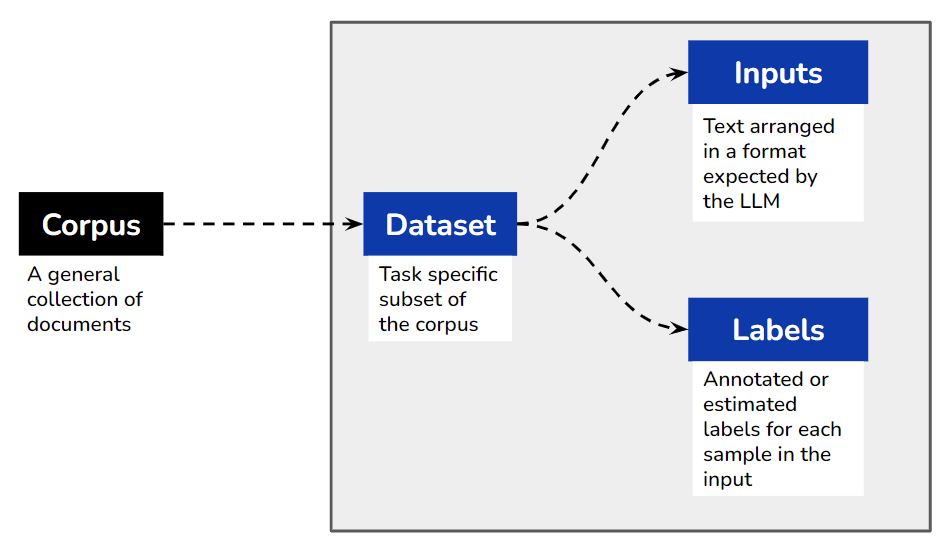

The key difference here is that the labels are not drawn from a predefined distribution. Construction of labels for text $→$ text tasks involves more effort, usually requiring multiple labelers that [brings its own challenges](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm).

For the abstractive summarization exercise, we use a [dataset of conversations and their summaries](https://huggingface.co/datasets/knkarthick/dialogsum), where each dialogue was summarized by a human. These dialogues belong to a wide variety of topics (7434 in total). We use this dataset to showcase how custom datasets should be prepared and used for prompt engineering.

In [ ]:
dataset = load_dataset("knkarthick/dialogsum")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
len(dataset['train']), len(dataset['validation']), len(dataset['test'])

(12460, 500, 1500)

In [ ]:
dialogue_summary_train_df = dataset['train'].to_pandas()
dialogue_summary_test_df = dataset['test'].to_pandas()

In [ ]:
dialogue_summary_train_df.sample(5)

,id,dialogue,summary,topic
12112,train_12112,"#Person1#: Jane, Professor Keller asked about ...",#Person1# tells Jane that Professor Keller ask...,development of project
2777,train_2777,#Person1#: I'm thinking about transfering out ...,#Person1# tells #Person2# #Person1# wants to t...,school transfer
3310,train_3310,"#Person1#: Just smell that, will you? Cool, is...",#Person1# and #Person2# are making pizza and t...,cooking
5668,train_5668,#Person1#: Here is your room. I hope you like ...,#Person1# introduces the hotel service to #Per...,hotel service
9675,train_9675,#Person1#: You look like a basket case.\n#Pers...,#Person2# complains to #Person1# about #Person...,guest issues


In [ ]:
dialogue_summary_train_df.topic.value_counts()

shopping                 174
job interview            161
daily casual talk        125
phone call                89
order food                79
                        ... 
eat ice creams             1
marriage predicaments      1
ways of commuting          1
food comment               1
baggage pack               1
Name: topic, Length: 7434, dtype: int64

This dataset was already split into train, validation and test. This is usually not the case for custom data. We will need to assemble a full training dataset, then create a small random split (usually 20%) to form the gold examples. These examples are fixed and used for evaluation only. The rest of the training data (usually 80%) is used to dynamically sample few-shot examples (that might vary for each draw).

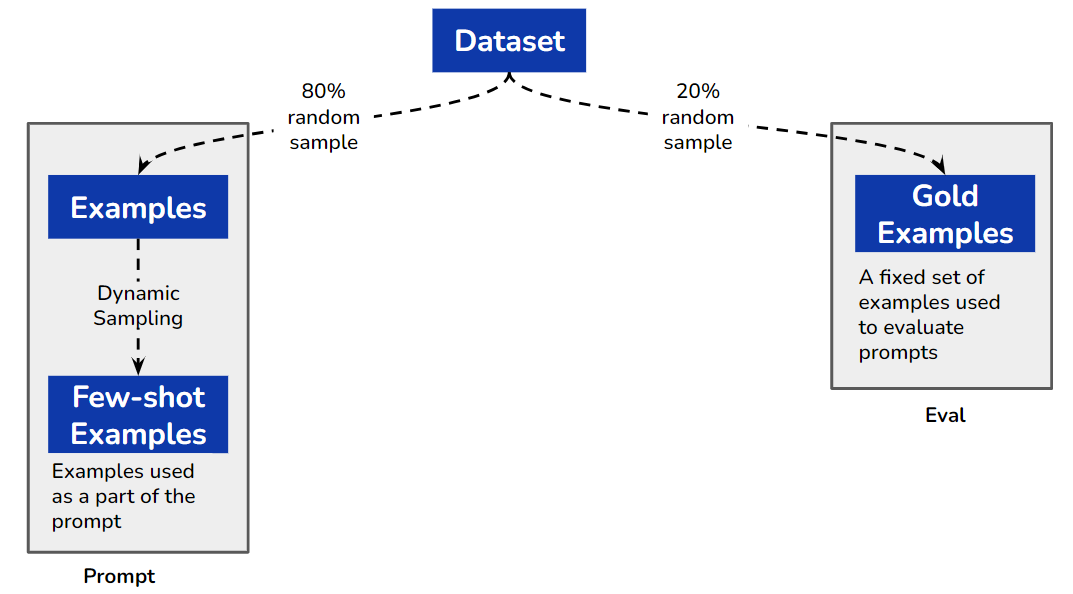

Let us sample 50 gold examples that will be held fixed for prompt evaluation (as depicted in the figure above).

In [ ]:
columns_to_select = ['dialogue', 'summary']

gold_examples = (
    dataset['test'].to_pandas()
                   .loc[:, columns_to_select]
                   .sample(50, random_state=42) # ensures that the gold examples are the same between sessions
                   .to_json(orient='records')
)

In [ ]:
len(json.loads(gold_examples))

50

In [ ]:
json.loads(gold_examples)[0]

{'dialogue': "#Person1#: Jack, I think it's best that I actively ask for the results of interview.\n#Person2#: That's a good idea! So you don't need to worry about it.\n#Person1#: I think so, too. What do you think about that I write a letter of inquiry to the company?\n#Person2#: It's OK. You could send an email to the employer via the internet.\n#Person1#: Good idea. It is convenient and fast.\n#Person2#: You could inquire about the results directly, but should be politely.\n#Person1#: Certainly.\n#Person2#: I think the letter of inquiry should be written briefly. If it's too long, I'm afraid the employer won't have time to read it.\n#Person1#: I think that about one hundred words are enough.\n#Person2#: After you send the letter of inquiry, you should pay close attention not to miss any reply.\n#Person1#: OK, I know now.",
 'summary': '#Person1# wants to know the result of a interview. Jack suggests writing a polite and brief email to the company.'}

### Step 3: Derive prompt

In [ ]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
Note that user input will be delimited by triple backticks that is, ```.
"""

In [ ]:
user_message_template = """"```{dialogue}```
"""

In [ ]:
assistant_message_template = "{summary}"

In [ ]:
def create_few_shot_prompt(system_message, dataset, n=8):

    """
    Return a prompt message in the format expected by the Open AI API.
    n examples are selected randomly from training data to form the few-shot
    prompt.
    We then loop through each example and parse the dialogue as the user message
    and the summary as the assistant message.
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]
    columns_to_select = ['dialogue', 'summary']

    examples = (
        dataset['train'].to_pandas()
                        .loc[:, columns_to_select]
                        .sample(n)
                        .to_json(orient='records')
    )

    for example in json.loads(examples):
        user_input_example = example['dialogue']
        assistant_output_example = example['summary']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    dialogue=user_input_example
                )
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': assistant_message_template.format(
                    summary=assistant_output_example
                )
            }
        )

    return few_shot_prompt

In [ ]:
few_shot_prompt = create_few_shot_prompt(system_message, dataset)

In [ ]:
num_tokens_from_messages(few_shot_prompt)

2298

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template, scorer, bert_score=False):

    """
    Return the ROUGE score or BERTScore for predictions on gold examples
    For each example we make a prediction using the prompt.
    Gold summaries and the AI generated summaries are aggregated into lists.
    These lists are used by the corresponding scorers to compute metrics.
    Since BERTScore is computed for each candidate-reference pair, we take the
    average F1 score across the gold examples.
    """

    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_dialogue = example['dialogue']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(dialogue=gold_dialogue)
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt + user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content']

            model_predictions.append(prediction)
            ground_truths.append([example['summary']])

        except Exception as e:
            print(e) # A better error handling mechanism could be implemented
            continue

    if bert_score:
        score = scorer.compute(
            predictions=model_predictions,
            references=ground_truths,
            lang="en",
            rescale_with_baseline=True
        )

        return sum(score['f1'])/len(score['f1'])
    else:
        return scorer.compute(
            predictions=model_predictions,
            references=ground_truths
        )

In [ ]:
rouge_scorer = evaluate.load("rouge")
bert_scorer = evaluate.load("bertscore")

In [ ]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    user_message_template,
    rouge_scorer
)

{'rouge1': 0.3690403258523205,
 'rouge2': 0.14628004553873294,
 'rougeL': 0.2985044325459695,
 'rougeLsum': 0.2981050034240351}

In [ ]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    user_message_template,
    bert_scorer,
    bert_score=True
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.4587234592437744

Since this is abstractive summarization, we focus on BERTScore as the evaluation metric. In this example, we get a BERTScore F1 of 0.45 with a set of 10 examples chosen at random from the training data to form the few-shot prompt. However, this is *one* choice of examples; we will need to run this evaluation multiple times to capture the variation in performance due to variation in the choice of few-shot examples.

As an example, let us run the evaluations 10 times, each time evaluating the model on BERTScore.

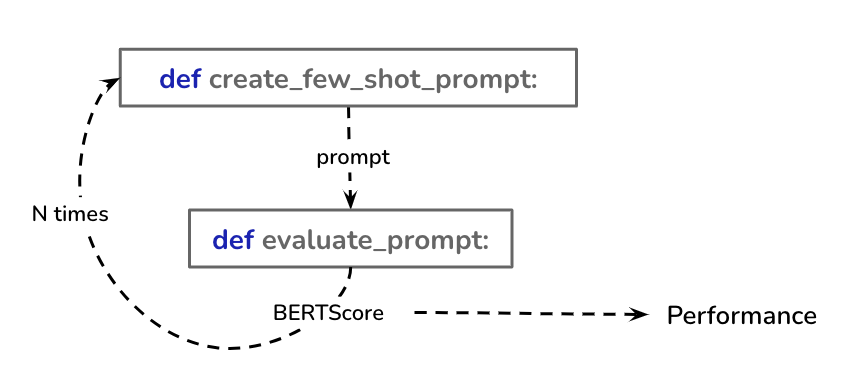

**Reminder: The following code should be run on a GPU runtime to avoid long running times**

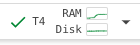

In [ ]:
num_eval_runs = 10

In [ ]:
few_shot_performance = []

In [ ]:
for _ in tqdm(range(num_eval_runs)):

    # For each run, create a new set of examples and compose the few-shot
    # prompt.
    few_shot_prompt = create_few_shot_prompt(system_message, dataset)

    # Compute BERTScore for the prompt assembled.
    # Gold examples remain the same for each evaluation.
    few_shot_bert_score = evaluate_prompt(
        few_shot_prompt,
        gold_examples,
        user_message_template,
        bert_scorer,
        bert_score=True
    )

    few_shot_performance.append(few_shot_bert_score)


100%|██████████| 10/10 [08:12<00:00, 49.28s/it]


In [ ]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.4490926484763622, 0.01784482270626792)

Across multiple evaluations, we expect the variability in BERTScore to be less (as is the case here).

Once we identify the correct prompt (in this case, it would amount to running variations of the system message prompt), we need to conduct the two sensitivity checks we saw in the case of text $→$ label tasks.

*Check 1: Bias*

We check if the prompt is generating a biased response by presenting a content free input (usually a blank, the string nothing or N/A). This check also acts as a guardrail for the situation where customer input is improperly received.

In [ ]:
bias_test_predictions = []

In [ ]:
few_shot_prompt = create_few_shot_prompt(system_message, dataset)

In [ ]:
for _ in tqdm(range(25)):

    user_input = [
        {
            'role':'user',
            'content': "```' '```" #<- content free test input
        }
    ]

    response = openai.ChatCompletion.create(
        deployment_id=chat_model_id,
        messages=few_shot_prompt + user_input,
        temperature=0,
        max_tokens=2
    )

    prediction = response['choices'][0]['message']['content']

    bias_test_predictions.append(prediction)

100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


In [ ]:
Counter(bias_test_predictions)

Counter({"I'm": 25})

The model should identify that no dialogue was presented to summarize.

*Check 2: Sensitity to number of examples*

To check if the performance of the prompt is sensitive to the number of examples used in the prompt, we vary the number of examples and ascertain that there is no dramatic difference in performance.

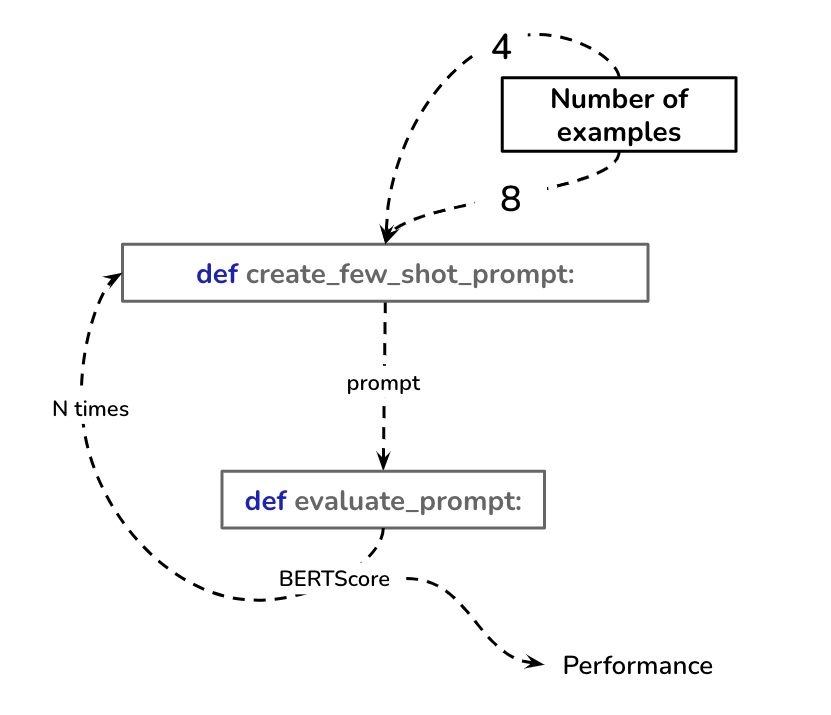

Note that using large number of examples impacts the cost of inference (we pay by token), so we should increase examples only if they have a substantial impact on performance.

In [ ]:
sample_size_sensitivity_results = []
num_examples_choice = [4, 8]

In [ ]:
for n in tqdm(num_examples_choice):

    for _ in range(10):

        few_shot_prompt = create_few_shot_prompt(system_message, dataset, n)

        bert_score_f1 = evaluate_prompt(
            few_shot_prompt,
            gold_examples,
            user_message_template,
            bert_scorer,
            bert_score=True
        )

        sample_size_sensitivity_results.append(
            {'num_examples': n, 'bert_score_f1': bert_score_f1}
        )

100%|██████████| 2/2 [15:55<00:00, 477.85s/it]


In [ ]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

bert_score_f1          
                      mean       std
num_examples                        
4                 0.443314  0.017450
8                 0.453312  0.015093

As we can see, the BERTScore is not sensitive to the number of examples chosen to be part of the few-shot prompt.

## Task 2: Question - Answering

Question-Answering (QA) tasks are very common in fields where significant expertise is needed (e.g., medicine, law). In QA tasks, an optional context might be provided to the model in order to guide it to the correct answer. Context is particularly important in domains where there is limited public data (e.g., finance, legal). Providing context is necessary given less domain-specific data in the training corpus. Hence, there is less chance for the model to have seen text from the domain.

There are two important types of QA we want our model to tackle:
- Factual (Objective) QA
- Subjective QA

Subjective QA follows the same format as text summarization. That is, we first assemble a set of questions (e.g., FAQs) and ask experts to annotate these with appropriate answers. Then we present these questions (+ optional context) to the model and use BERTScore to measure how close the output from the model is to the answer written by an expert. We will look at subjective QA more closely when we do Retrieval Augmented Generation (RAG) later.

For now let us focus on factual QA, where the objective is to select the correct answer from a set of multiple choice options provided to the model. For factual QA, the knowledge base that the model was exposed to during pretraining becomes critical.

### Step 1: Define objectives and metrics

Since we will prompt the model to pick the correct answer from a set of options (the objective), we can use accuracy as the metric.

### Step 2: Assemble data

To illustrate multiple-choice question answering, we use a dataset of [medical questions and answers](https://huggingface.co/datasets/medmcqa) that was annotated with a correct answer and an expert explanation. We discard the explanation and focus only on the answer options and the choice of the correct answer.

In [ ]:
medmcqa_corpus = load_dataset("medmcqa")

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [ ]:
medmcqa_corpus

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

The test data does not have the correct labels, so we choose the validation data as a source of gold examples. Like before, usually we select a dataset from a corpus and then create a examples-gold examples split from this dataset. Here, these steps were already conducted for us.

In [ ]:
medmcqa_train_df = medmcqa_corpus['train'].to_pandas()
medmcqa_valid_df = medmcqa_corpus['validation'].to_pandas()

In [ ]:
medmcqa_train_df.sample(5)

,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
63844,c58768e0-a1ad-47af-97d2-12d40147876b,A known case of COPD with acute exacerbation o...,I/V steroids,Inhalation with salbutamol,Permissible hypercapnia allowed,Non invasive ventilation is contraindicated,3,multi,Management of COPD with acute exacerbation of ...,Medicine,NEET Jan 2020
49687,27622a27-5fac-4637-b2cb-5d5dd8d5a64d,Which of the following is the 'Least common' c...,Diarrhea,Pneumonia,Otitis media,SSPE,3,single,Ans. (d) SSPE Complication of Measles Otitis m...,Microbiology,None
24884,a69bc4e5-ac36-4050-b605-735517e76573,Diagnostic test for HIV in window period is?,ELISA,Western blot,P 24 antigen,Viral load,2,single,ANSWER: (C) P 24 antigenREF: Harrisons Interna...,Medicine,Virology
98557,a683984a-3d6a-4a83-8c3b-089579992af0,True about Rheumatic carditis –,Only endocarditis,Only myocarditis,Only Pericarditis,Pancarditis,3,multi,Rheumatic carditis\n\nSeen in 40-60% of patien...,Pediatrics,None
117703,fbbfffbd-5674-4888-8e75-96e1580cb5c5,Socratic of education consists of all except -,Lecture,Group discussion,Seminar,Panel discussion,0,multi,"Ans. is 'a' i.e., Lecture Lecture is didactic ...",Social & Preventive Medicine,None


As can be seen from the table above, each question has four options (`opa`, `opb`, `opc` and `opd`). Questions might have more than one answer.

In [ ]:
medmcqa_train_df.subject_name.value_counts()

Medicine                        17887
Surgery                         16862
Pathology                       14884
Anatomy                         14560
Pharmacology                    13758
Social & Preventive Medicine    11882
Microbiology                    11314
Gynaecology & Obstetrics        10013
Dental                           8938
Physiology                       8830
Biochemistry                     8282
Pediatrics                       8037
Ophthalmology                    6932
Forensic Medicine                5900
ENT                              4919
Psychiatry                       4442
Radiology                        4395
Anaesthesia                      3172
Unknown                          3045
Orthopaedics                     2999
Skin                             1771
Name: subject_name, dtype: int64

In [ ]:
medmcqa_valid_df.subject_name.value_counts()

Dental                          1318
Surgery                          369
Pathology                        337
Medicine                         295
Pharmacology                     243
Anatomy                          234
Pediatrics                       234
Gynaecology & Obstetrics         224
Physiology                       171
Biochemistry                     171
Social & Preventive Medicine     129
Microbiology                     122
Radiology                         69
Forensic Medicine                 67
Ophthalmology                     58
ENT                               53
Anaesthesia                       34
Orthopaedics                      20
Skin                              17
Psychiatry                        16
Unknown                            2
Name: subject_name, dtype: int64

In [ ]:
columns_to_select = ['question', 'opa', 'opb', 'opc', 'opd', 'cop']

In [ ]:
gold_examples = (
    medmcqa_valid_df.query("choice_type == 'single'")
                    .loc[:, columns_to_select]
                    .sample(100, random_state=42) #<- ensures that gold examples are the same for every session
                    .to_json(orient='records')
)

### Step 3: Derive prompt

In [ ]:
few_shot_system_message = """
Pick the correct option for the question presented in the input delimited by triple backticks, that is, ```.
Each question will be from the medical domain and will have only one correct answer.
Questions will begin with the keyword ###Question.
The answer to these questions needs to be picked from four options (0, 1, 2, and 3) presented in the section beginning with ###Options.
Remember that there is only one correct answer for each question.
Respond only with the number of the correct option, that is, 0, 1, 2, or 3.
"""

In [ ]:
user_message_template ="""
```
###Question
{question}

###Options
0. {opa}
1. {opb}
2. {opc}
3. {opd}
```
"""

Examples could be assembled like so:

In [ ]:
examples = (
    medmcqa_train_df.query("choice_type == 'single'")
                    .loc[:, columns_to_select]
                    .sample(16)
                    .to_json(orient='records')
)

In [ ]:
json.loads(examples)

[{'question': 'Which tarsal bone articulates with the tibia and fibula?',
  'opa': 'calcaneus',
  'opb': 'cuboid',
  'opc': 'navicular',
  'opd': 'talus',
  'cop': 3},
 {'question': 'Which of the following is not a neurotic defense mechanism?',
  'opa': 'Isolation',
  'opb': 'Regression',
  'opc': 'Reaction formation',
  'opd': 'Undoing',
  'cop': 1},
 {'question': 'Dubration of training of ASHA worker is?',
  'opa': '21 days',
  'opb': '23 days',
  'opc': '30 days',
  'opd': '35 days',
  'cop': 1},
 {'question': "Treatment of choice for Eale's disease ?",
  'opa': 'Antibiotics',
  'opb': 'Coicosteroids',
  'opc': 'Antihistaminics',
  'opd': 'Surgery',
  'cop': 0},
 {'question': 'A viral organism was isolated from a painful blister on the lip of a girl. The agent was found to double-stranded, linear DNA and was enveloped. Most likely causative organism is:',
  'opa': 'EBV',
  'opb': 'HSV',
  'opc': 'CMV',
  'opd': 'Pox',
  'cop': 1},
 {'question': 'Predominant ion in saliva is',
  'opa

Let us wrap this logic into a function to create a few-shot prompt.

In [ ]:
def create_few_shot_prompt(system_message, user_message_template, dataset, n=8):

    """
    Return a prompt message in the format expected by the Open AI API.
    n examples are selected randomly from training data to form the few-shot
    prompt.
    We then loop through each example and parse the question and options as the
    user message and the correct option as the assistant message.
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]
    columns_to_select = ['question', 'opa', 'opb', 'opc', 'opd', 'cop']

    examples = (
        dataset['train'].to_pandas()
                        .query("choice_type == 'single'")
                        .loc[:, columns_to_select]
                        .sample(n)
                        .to_json(orient='records')
    )

    for example in json.loads(examples):
        example_question = example['question']
        option_a = example['opa']
        option_b = example['opb']
        option_c = example['opc']
        option_d = example['opd']

        assistant_output_example = example['cop']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    question=example_question,
                    opa=option_a,
                    opb=option_b,
                    opc=option_c,
                    opd=option_d
                )
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': str(assistant_output_example) # convert integer to string since GPT accepts only text input
            }
        )

    return few_shot_prompt

In [ ]:
few_shot_prompt = create_few_shot_prompt(
    few_shot_system_message,
    user_message_template,
    medmcqa_corpus
)

In [ ]:
num_tokens_from_messages(few_shot_prompt)

639

In [ ]:
def evaluate_prompt(prompt, gold_examples, user_message_template):

    """
    Return the accuracy for predictions on gold examples.
    For each example we make a prediction using the prompt.
    Gold answers and the AI generated answers are aggregated into lists.
    The numpy .mean() function is used to compute accuracy by comparing these
    two lists.
    """

    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_question = example['question']
        gold_option_a = example['opa']
        gold_option_b = example['opb']
        gold_option_c = example['opc']
        gold_option_d = example['opd']

        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(
                    question=gold_question,
                    opa=gold_option_a,
                    opb=gold_option_b,
                    opc=gold_option_c,
                    opd=gold_option_d
                )
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt + user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content']

            model_predictions.append(int(prediction)) # string converted back to integer
            ground_truths.append(example['cop'])

        except Exception as e:
            print(e) # A better error handling mechanism could be implemented
            continue

    return (np.array(model_predictions) == np.array(ground_truths)).mean()

In [ ]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

0.56

However, this accuracy is for *one* iteration. Let us see how the accuracy varies across different selection of few-shot examples.

In [ ]:
few_shot_performance = []
num_eval_runs = 10

for _ in tqdm(range(num_eval_runs)):

    # Assemble the few shot prompt
    few_shot_prompt = create_few_shot_prompt(
        few_shot_system_message,
        user_message_template,
        medmcqa_corpus
    )

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(
        few_shot_prompt,
        gold_examples,
        user_message_template
    )

    few_shot_performance.append(few_shot_accuracy)

100%|██████████| 10/10 [05:56<00:00, 35.68s/it]


In [ ]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.554, 0.011999999999999972)

*Check 1: Bias*

In [ ]:
bias_test_predictions = []

In [ ]:
few_shot_prompt = create_few_shot_prompt(
        few_shot_system_message,
        user_message_template,
        medmcqa_corpus
)

In [ ]:
for _ in tqdm(range(25)):

    user_input = [
        {
            'role':'user',
            'content': "```' '```" #<- content free test input
        }
    ]

    response = openai.ChatCompletion.create(
        deployment_id=chat_model_id,
        messages=few_shot_prompt + user_input,
        temperature=0,
        max_tokens=2
    )

    prediction = response['choices'][0]['message']['content']

    bias_test_predictions.append(prediction)

100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


In [ ]:
Counter(bias_test_predictions)

Counter({"I'm": 25})

*Check 2: Sensitivity to number of examples*

In [ ]:
sample_size_sensitivity_results = []
num_examples_choice = [4, 8, 16, 32]

In [ ]:
for num_examples in tqdm(num_examples_choice):

    for _ in range(10):

        few_shot_prompt = create_few_shot_prompt(
            few_shot_system_message,
            user_message_template,
            medmcqa_corpus,
            n=num_examples
        )

        few_shot_accuracy = evaluate_prompt(
            few_shot_prompt,
            gold_examples,
            user_message_template
        )

        sample_size_sensitivity_results.append(
            {'num_examples': num_examples, 'accuracy': few_shot_accuracy}
        )

100%|██████████| 4/4 [25:05<00:00, 376.30s/it]


In [ ]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

accuracy          
                 mean       std
num_examples                   
4               0.560  0.018257
8               0.559  0.015239
16              0.555  0.021731
32              0.581  0.026013

As we can see from the table above, there is not much difference in accuracy due to the number of examples chosen to be a part of the few-shot prompt.

# Summary

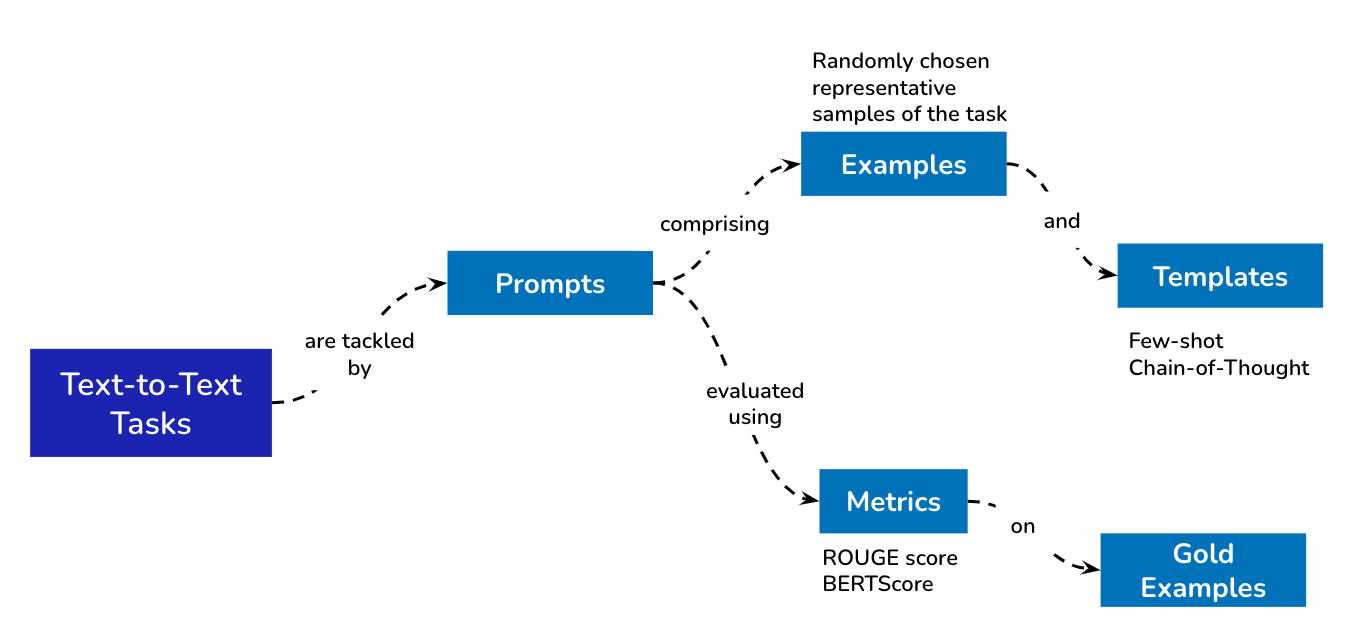

# Additional Material

This is additional code that was used to create visuals for the exposition on ROUGE score and BERTScore.

In [ ]:
import string

In [ ]:
def remove_punctuation_and_lowercase(sentence):
    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Remove punctuation and convert to lowercase
    cleaned_sentence = sentence.translate(translator).lower()

    return cleaned_sentence

In [ ]:
def generate_ngrams(sentence, n):

    cleaned_sentence = remove_punctuation_and_lowercase(sentence)

    # Tokenize the sentence into words
    words = cleaned_sentence.split()

    # Generate n-grams
    ngrams = [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]

    return ngrams

In [ ]:
def find_matching_ngrams(sentence1, sentence2, n):
    # Generate n-grams for both sentences
    ngrams1 = generate_ngrams(sentence1, n)
    ngrams2 = generate_ngrams(sentence2, n)

    # Convert n-grams to sets for faster intersection
    ngram_set1 = set(ngrams1)
    ngram_set2 = set(ngrams2)

    # Find matching n-grams
    matching_ngrams = ngram_set1.intersection(ngram_set2)

    return matching_ngrams

In [ ]:
def len_of_ngrams(sentence, n):
    ngrams = set(generate_ngrams(sentence, n))
    return len(ngrams)

In [ ]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

In [ ]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    1
)

print("Matching 1-grams:", matching_ngrams)
print("Number of 1-grams (human):", len_of_ngrams(human_generated_summary, 1)) # For ROUGE
print("Number of 1-grams (AI):", len_of_ngrams(ai_generated_summary, 1))

Matching 1-grams: {('defects',), ('and',), ('glitches',), ('a',), ('camera',)}
Number of 1-grams (human): 17
Number of 1-grams (AI): 10


In [ ]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    2
)

print("Matching 2-grams:", matching_ngrams)
print("Number of 2-grams (human):", len_of_ngrams(human_generated_summary, 2)) # For ROUGE
print("Number of 2-grams (AI):", len_of_ngrams(ai_generated_summary, 2))

Matching 2-grams: {('glitches', 'defects'), ('and', 'a'), ('defects', 'and')}
Number of 2-grams (human): 16
Number of 2-grams (AI): 9


In [ ]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    3
)

print("Matching 3-grams:", matching_ngrams)
print("Number of 3-grams (human):", len_of_ngrams(human_generated_summary, 3))
print("Number of 3-grams (AI):", len_of_ngrams(ai_generated_summary, 3))

Matching 3-grams: {('defects', 'and', 'a'), ('glitches', 'defects', 'and')}
Number of 3-grams (human): 15
Number of 3-grams (AI): 8


In [ ]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    4
)

print("Matching 4-grams:", matching_ngrams)
print("Number of 4-grams (human):", len_of_ngrams(human_generated_summary, 4))
print("Number of 4-grams (AI):", len_of_ngrams(ai_generated_summary, 4))

Matching 4-grams: {('glitches', 'defects', 'and', 'a')}
Number of 4-grams (human): 14
Number of 4-grams (AI): 7


In [ ]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    5
)

print("Matching 5-grams:", matching_ngrams)
print("Number of 5-grams (human):", len_of_ngrams(human_generated_summary, 5))
print("Number of 5-grams (AI):", len_of_ngrams(ai_generated_summary, 5))

Matching 5-grams: set()
Number of 5-grams (human): 13
Number of 5-grams (AI): 6


In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
rouge_score.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    tokenizer=lambda x: remove_punctuation_and_lowercase(x).split()
)

{'rouge1': 0.37037037037037035,
 'rouge2': 0.24000000000000005,
 'rougeL': 0.37037037037037035,
 'rougeLsum': 0.37037037037037035}

In [ ]:
r_lcs, p_lcs = 5/17, 5/10
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs)

0.37037037037037035

In [ ]:
bert_score = evaluate.load("bertscore")

In [ ]:
bert_score.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    lang='en'
)

(…)o/roberta-large/resolve/main/config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

(…)co/roberta-large/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)co/roberta-large/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)oberta-large/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9408690333366394],
 'recall': [0.9137743711471558],
 'f1': [0.9271237850189209],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.34.0)'}

In [ ]:
from bert_score import score, plot_example

In [ ]:
ai_generated_summary = "Major issues, malfunctioning camera."
human_generated_summary = "Severely disappointed, constant problems."

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


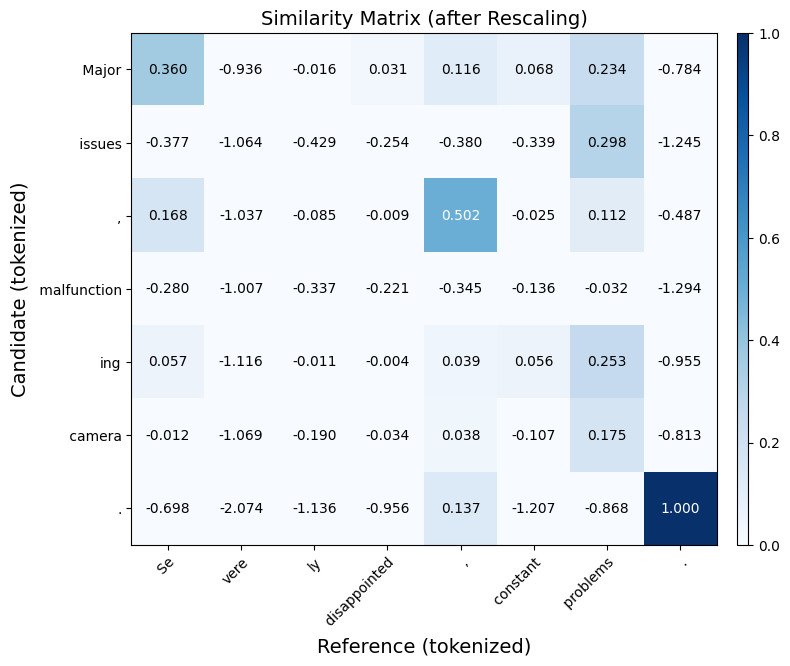

In [ ]:
plot_example(
    ai_generated_summary,
    human_generated_summary,
    lang="en",
    rescale_with_baseline=True
)

In [ ]:
P, R, F1 = score(
    [ai_generated_summary],
    [human_generated_summary],
    lang="en",
    rescale_with_baseline=True
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
P, R, F1

(tensor([0.3640]), tensor([0.1705]), tensor([0.2666]))

In [ ]:
(2 * P * R)/(P + R) # This is then rescaled to reach 0.2666

tensor([0.2322])